# ELSA evaluation

This notebook contains the details and codes to evaluate the ELSA algorithm (with/without postprocessing) and compare it to EASE. Tested on Python 3.11.1.

First, let's get the data from the database. If you want to use example data, change the `USE_EXAMPLE_DATA` variable to `True`.

In [1]:
import pandas as pd
import sqlite3
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# configuration
USE_EXAMPLE_DATA = True # change to True to use example data, False to use data from the database
N_ITERATIONS = 4 # number of iterations in the study
DB_FILE_PATH = '../server/instance/db.sqlite'
USER_STUDY_ID = 11
# end of configuration

if not USE_EXAMPLE_DATA:
    conn = sqlite3.connect(DB_FILE_PATH, isolation_level=None, detect_types=sqlite3.PARSE_COLNAMES)
    interaction_df = pd.read_sql_query("SELECT * FROM interaction", conn)
    participation_df = pd.read_sql_query("SELECT * FROM participation", conn)

Now, we have to filter out sensitive information and users that have not completed the user study. Also, prior to this, we have to delete all interactions with the system that are not related to the user study. We will do this by filtering out the data by timestamp (as the user study does not have an unique identifier - see https://github.com/pdokoupil/EasyStudy/issues/4).

In [2]:
if not USE_EXAMPLE_DATA:
    # filter out data before the initial date
    initial_date = "2024-06-12 00:00:00"
    participation_df = participation_df[participation_df.time_joined >= initial_date]
    participation_df = participation_df[participation_df.study_id == USER_STUDY_ID]
    interaction_df = interaction_df[interaction_df.time >= initial_date]

    # filter out unfinished participations
    participation_df = participation_df[participation_df.age_group.notna()]
    participation_df_completed = participation_df[participation_df.time_finished.notna()]

    # remove sensitive data and save for further usage
    participation_df_completed = participation_df_completed.drop(["participant_email","extra_data"], axis=1)
    participation_df_completed.to_csv("data/participation.csv", index=False)

    # filter out interactions of participants who didn't complete the study
    def get_participants_interaction(df_i, df_p):
        return df_i[df_i.participation.isin(df_p.index + 1)]

    interaction_df = get_participants_interaction(interaction_df, participation_df_completed)
    interaction_df.to_json("data/interaction.json", index=False)

if USE_EXAMPLE_DATA:
    interaction_df = pd.read_json("data/examples/interaction.json")
    participation_df_completed = pd.read_csv("data/examples/participation.csv")

# extract the algorithm names from the interaction data
def extract_algorithms(df):
    algorithms = []
    df_copy = df[df.interaction_type == "iteration-started"]
    first_interaction = df_copy.iloc[0]
    algorithm_assignment = json.loads(first_interaction.data)["algorithm_assignment"]
    for key in algorithm_assignment:
        algorithms.append(algorithm_assignment[key]["name"])
        
    return algorithms

algorithms = extract_algorithms(interaction_df)

Now, let's load the data and retrieve some information from the interactions dataset.

In [3]:
def get_iteration(x):
    return json.loads(x)["iteration"]

def set_iteration(row):
    if row.interaction_type == "iteration-started" or row.interaction_type == "iteration-ended":
        row['iteration'] = json.loads(row.data)['iteration']
    else:
        row['iteration'] = None
    return row

def set_result_layout(row):
    if row.interaction_type == "iteration-started":
        row['result_layout'] = json.loads(row.data)['result_layout']
    else:
        row['result_layout'] = None
    return row

def set_mapping(row):
    if row.interaction_type == 'iteration-started':
        dat = json.loads(row.data)['algorithm_assignment'].values()
        for mapping in dat:
            row[mapping['name'].upper()] = mapping['order']
    else:
        for algorithm in algorithms:
            row[algorithm.upper()] = None
    return row

d = interaction_df.copy().set_index("id")
d = d.apply(set_iteration, axis=1).apply(set_result_layout, axis=1).apply(set_mapping, axis=1)

columns_to_ffill = ['iteration', 'result_layout'] + [algorithm.upper() for algorithm in algorithms]

for column in columns_to_ffill:
    d[column] = d.groupby(['participation'], sort=False)[column].ffill()

d = d[d.iteration.notna()]

In [4]:
d

,participation,interaction_type,time,data,iteration,result_layout,EASE,ELSA_POSTPROCESSING,ELSA_VANILLA
id,,,,,,,,,
1169,18,iteration-started,2024-06-12 12:52:03.229305,"{""iteration"": 1, ""movies"": {""EASE"": {""movies"":...",1.0,column-single,1.0,0.0,2.0
1170,18,loaded-page,2024-06-12 12:52:03.597280,"{""page"": ""compare_algorithms"", ""context"": {""ur...",1.0,column-single,1.0,0.0,2.0
1171,18,changed-viewport,2024-06-12 12:52:04.375029,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 16...",1.0,column-single,1.0,0.0,2.0
1172,18,changed-viewport,2024-06-12 12:52:05.787655,"{""viewport"": {""left"": 0, ""top"": -16, ""width"": ...",1.0,column-single,1.0,0.0,2.0
1173,18,changed-viewport,2024-06-12 12:52:07.495012,"{""viewport"": {""left"": 0, ""top"": -2213.33349609...",1.0,column-single,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...
1956,20,study-ended,2024-06-15 20:52:46.406125,"{""iteration"": 4}",4.0,column-single,1.0,2.0,0.0
1957,20,loaded-page,2024-06-15 20:52:46.698972,"{""page"": ""finished_user_study"", ""context"": {""u...",4.0,column-single,1.0,2.0,0.0
1958,20,changed-viewport,2024-06-15 20:52:46.909963,"{""viewport"": {""left"": 0, ""top"": 0, ""width"": 17...",4.0,column-single,1.0,2.0,0.0


In [5]:
# adding information on whether the selected item was displayed on an advantaged position (variant=0), or not (variant=1)
d["variant"] = -1
d.loc[d["interaction_type"] == "selected-item", "variant"] = d[d["interaction_type"] == "selected-item"].data.map(lambda x: json.loads(x)["selected_item"]).map(lambda x: x.get("variant", -1))

selected_item_interactions = d[d.variant >= 0].copy()
# adding information on corresponding MovieID
def getSelectedMovieId(x):
    return json.loads(x)["selected_item"]["movie_id"]

selected_item_interactions["movieID"] = np.nan
selected_item_interactions.movieID = selected_item_interactions.data.map(lambda x: getSelectedMovieId(x))

selected_item_interactions["selected_algorithm"] = ""

# for each selected item interaction, get the corresponding algorithm
for i in range(len(algorithms)):
    algorithm = algorithms[i]
    selected_item_interactions.loc[selected_item_interactions.variant.astype("int") == i, "selected_algorithm"] = algorithm

We have the information about the algorithms that were preferred by the users. Let's see which algorithms were preferred by the users. Note that these statistics do not mean that the users found the algorithm to be better - if the user selects an item from one algorithm and the item appears in the other algorithm as well, it only counts as a preference for the first algorithm. This makes the statistics biased towards the first algorithm selected.

In [6]:
# group items by selected algorithm and count them
selected_item_interactions.groupby("selected_algorithm").size()

selected_algorithm
EASE                   45
ELSA_postprocessing    20
ELSA_vanilla           16
dtype: int64

Let's have a look at the results and compare ELSA (both with and without postprocessing) and EASE. The first interesting metric is the number of common items between the algorithms (Jaccard similarity). This metric is important as it shows how much the algorithms differ in their recommendations.

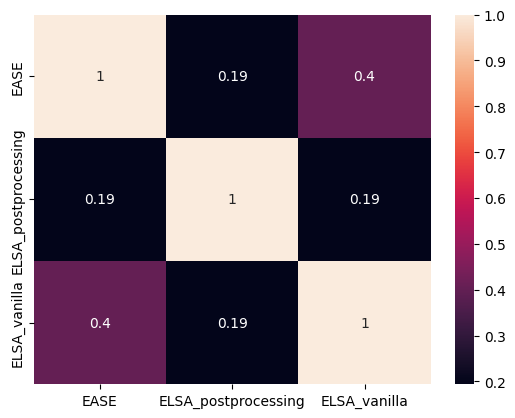

In [7]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

# for all of the "iteration-started" interactions (distinct by participation id), get all of the selected items
iteration_started_groupby_part = d[d.interaction_type == "iteration-started"].groupby("participation").data.apply(lambda x: x.tolist())
for i in range(len(iteration_started_groupby_part)):
    algos = { a: [] for a in algorithms }
    # go through every iteration and append the shown items to the corresponding algorithm
    for idx, item in enumerate(iteration_started_groupby_part.iloc[i]):
        json_item = json.loads(item)
        shown = json_item["shown"]
        for s in shown:
            algos[s].extend(shown[s][idx])

# compute the Jaccard similarity between the shown items for each algorithm
# and save it to the dictionary
matrix = {a: {b: jaccard_similarity(algos[a], algos[b]) for b in algos} for a in algos}
sns.heatmap(pd.DataFrame(matrix), annot=True)
plt.show()

As we can see, ELSA without postprocessing has higher Jaccard similarity with EASE than ELSA with postprocessing. This is expected, as the postprocessing step is designed to make the recommendations more diverse. We may also see that ELSA with and without postprocessing have pretty low Jaccard similarity, which means that the postprocessing step is making a difference.

Let's evaluate the diversity of recommendations with respect to genres, which might show the real difference between the algorithms.

EASE, genres selected: 89: ['Thriller', 'Drama', 'Comedy', 'Drama', 'Drama', 'Comedy', 'Thriller', 'Comedy', 'Comedy', 'Drama', 'Thriller', 'Crime', 'Romance', 'War', 'Mystery', 'Thriller', 'Drama', 'Crime', 'Drama', 'Crime', 'Drama', 'Drama', 'IMAX', 'Film-Noir', 'Mystery', 'Crime', 'Drama', 'Mystery', 'Drama', 'Thriller', 'IMAX', 'Comedy', 'Drama', 'Crime', 'Drama', 'Thriller', 'Crime', 'Drama', 'Thriller', 'Sci-Fi', 'Thriller', 'Romance', 'Comedy', 'Mystery', 'Thriller', 'Thriller', 'Drama', 'Thriller', 'Drama', 'Comedy', 'Romance', 'Fantasy', 'Romance', 'Mystery', 'Romance', 'Thriller', 'IMAX', 'Mystery', 'Thriller', 'Thriller', 'Comedy', 'Romance', 'War', 'Fantasy', 'Drama', 'Sci-Fi', 'Mystery', 'Drama', 'Thriller', 'War', 'Action', 'Thriller', 'IMAX', 'Thriller', 'Action', 'Fantasy', 'IMAX', 'Drama', 'Thriller', 'Western', 'Action', 'Drama', 'War', 'Drama', 'Thriller', 'Romance', 'War', 'Drama', 'War']
ELSA_postprocessing, genres selected: 39: ['Drama', 'Romance', 'Sci-Fi', 'Myst

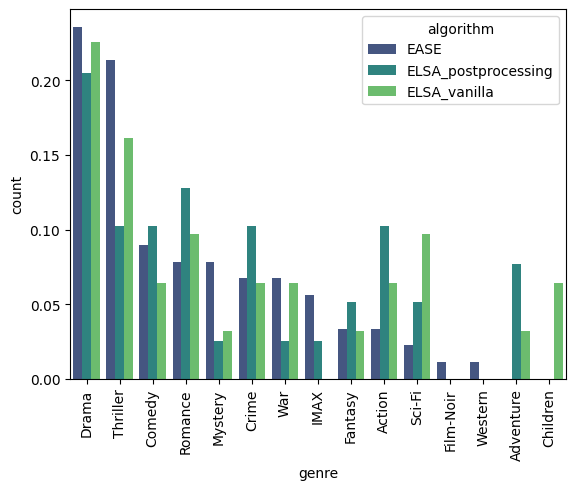

In [8]:
genres_by_algorithm = { a: [] for a in algorithms }
for item_sel in selected_item_interactions.iterrows():
    value = item_sel[1]
    algorithm = value["selected_algorithm"]
    genres_list = json.loads(value["data"])["selected_item"]["genres"]
    # pick 2 random genres from the list...
    # this is not a perfect solution, but some movies have multiple genres
    # and it would be bad to count the first one as they are sorted alphabetically
    if len(genres_list) < 2:
        genres_by_algorithm[algorithm].extend(genres_list)
        continue
    np.random.seed(42069)
    genres = np.random.choice(genres_list, 2, replace=False)
    genres_by_algorithm[algorithm].extend(genres)

def process_genres_show_plot(genres_by_algorithm):
    final_pd = pd.DataFrame()

    for algorithm in genres_by_algorithm:
        print(f"{algorithm}, genres selected: {len(genres_by_algorithm[algorithm])}: {genres_by_algorithm[algorithm]}")
        genres_pd = pd.DataFrame(genres_by_algorithm[algorithm], columns=["genre"])
        genres_pd_normalized = genres_pd.stack().value_counts(normalize=True).reset_index()
        genres_pd_normalized["algorithm"] = algorithm
        final_pd = pd.concat([final_pd, genres_pd_normalized])

    final_pd.columns = ["genre", "count", "algorithm"]
    sns.barplot(data=final_pd, x="genre", y="count", hue="algorithm", palette="viridis")
    plt.xticks(rotation=90)
    plt.show()

process_genres_show_plot(genres_by_algorithm)

We have done that just for the selected items, but we can also do that for all items. Let's see the results.

EASE, genres selected: 228: ['Crime', 'Drama', 'Drama', 'Romance', 'Sci-Fi', 'Mystery', 'Thriller', 'Mystery', 'Thriller', 'Comedy', 'Sci-Fi', 'Comedy', 'Drama', 'Thriller', 'Crime', 'Drama', 'Drama', 'Sci-Fi', 'Thriller', 'Comedy', 'Sci-Fi', 'Thriller', 'Crime', 'Thriller', 'Comedy', 'Comedy', 'Romance', 'Sci-Fi', 'IMAX', 'Thriller', 'Drama', 'Thriller', 'Crime', 'Western', 'Action', 'Romance', 'War', 'Thriller', 'Crime', 'Thriller', 'Drama', 'Drama', 'Romance', 'Drama', 'Action', 'Crime', 'Drama', 'Comedy', 'Crime', 'Drama', 'Thriller', 'Crime', 'Drama', 'Drama', 'IMAX', 'War', 'Action', 'Romance', 'Comedy', 'Thriller', 'IMAX', 'Drama', 'Crime', 'Drama', 'Crime', 'IMAX', 'Comedy', 'Drama', 'Film-Noir', 'Mystery', 'Crime', 'Drama', 'IMAX', 'Action', 'Crime', 'Thriller', 'Crime', 'Drama', 'Romance', 'Crime', 'Thriller', 'Crime', 'Western', 'Action', 'Romance', 'Comedy', 'Drama', 'Drama', 'Thriller', 'Crime', 'Drama', 'Drama', 'Drama', 'Thriller', 'Thriller', 'Crime', 'Crime', 'Thriller

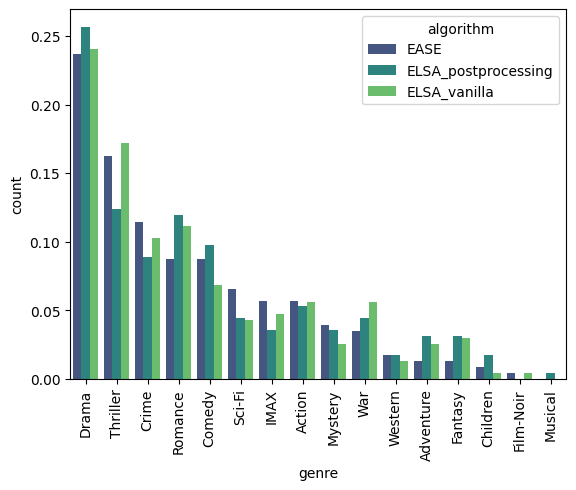

In [9]:
genres_by_algorithm = { a: [] for a in algorithms }

for i in range(len(iteration_started_groupby_part)):
    algos = { a: [] for a in algorithms }
    # go through every iteration and append the shown items to the corresponding algorithm
    for idx, item in enumerate(iteration_started_groupby_part.iloc[i]):
        json_item = json.loads(item)
        for algorithm in json_item["movies"]:
            for movie in json_item["movies"][algorithm]["movies"]:
                genres_list = movie["genres"]
                if len(genres_list) < 2:
                    genres_by_algorithm[algorithm].extend(genres_list)
                    continue
                np.random.seed(42069)
                genres = np.random.choice(genres_list, 2, replace=False)
                genres_by_algorithm[algorithm].extend(genres)

process_genres_show_plot(genres_by_algorithm)

It seems like the postprocessing step is making the recommendations more diverse, but not in a really significant way - this might be caused by the fact that the users have selected similar items during the elicitation process, moreover, there are many drama movies and thrillers in the dataset.

Another interesting metric that could be evaluated is the novelty with respect to the year of release. Let's do it for all recommendations - the selected items could be biased.

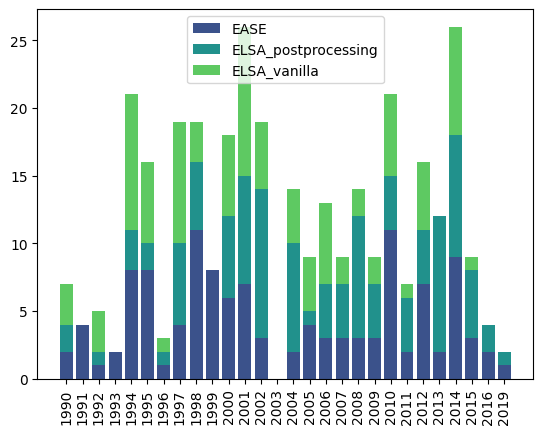

Mean year for EASE: 2003.2
Mean year for ELSA_postprocessing: 2005.6
Mean year for ELSA_vanilla: 2001.4


In [10]:
def extract_year_from_movieName(name):
    pattern = re.compile(r'\((\d{4})\)')
    year = re.search(pattern, name)
    year_content = year.group(1)
    return year_content

years_by_algorithm = { a: [] for a in algorithms }

for i in range(len(iteration_started_groupby_part)):
    algos = { a: [] for a in algorithms }
    for idx, item in enumerate(iteration_started_groupby_part.iloc[i]):
        json_item = json.loads(item)
        for algorithm in json_item["movies"]:
            for movie in json_item["movies"][algorithm]["movies"]:
                movie_name = movie["movie"]
                years_by_algorithm[algorithm].append(extract_year_from_movieName(movie_name))

def process_years_show_plot(years_by_algorithm):
    final_pd = pd.DataFrame()

    for algorithm in years_by_algorithm:
        years_pd = pd.DataFrame(years_by_algorithm[algorithm], columns=["year"])
        years_pd_normalized = years_pd.stack().value_counts(normalize=False).reset_index()
        years_pd_normalized["algorithm"] = algorithm
        final_pd = pd.concat([final_pd, years_pd_normalized])

    final_pd.columns = ["year", "count", "algorithm"]
    final_pd = final_pd.sort_values(by="year")
    pivot_df = final_pd.pivot(index='year', columns='algorithm', values='count')
    fig, ax = plt.subplots()
    palette = sns.color_palette("viridis", n_colors=len(pivot_df.columns))
    bottom_values = [0] * len(pivot_df)
    for i, column in enumerate(pivot_df.columns):
        ax.bar(pivot_df.index, pivot_df[column], bottom=bottom_values, color=palette[i], label=column)
        bottom_values += pivot_df[column]
    
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

process_years_show_plot(years_by_algorithm)
for algorithm in years_by_algorithm:
    years = years_by_algorithm[algorithm]
    years = [int(year) for year in years]
    mean_year = round(np.mean(years), 1)
    print(f"Mean year for {algorithm}: {mean_year}")

It seems like the novelty postprocessing works as expected. The recommendations from ELSA with postprocessing are more novel than the recommendations from ELSA without postprocessing and EASE.

In conclusion, we have succesfully integrated the ELSA algorithm into the EasyStudy system and evaluated it with respect to the EASE algorithm (at least for a few users). The results show that the recommendations may be more diverse and novel when using ELSA with postprocessing. On the other side, more research and data would be needed to evaluate the performance in a statistically significant way. Moreover, more parameter combinations should be tested to find the best postprocessing parameter values.